# Защита персональных данных клиентов

**Описание описание**

Необходимо защитить данные клиентов страховой компании «Хоть потоп». Разработать **метод преобразования данных**, чтобы по ним было сложно восстановить **персональную информацию**. Обоснуйте корректность его работы.

Следует учитывать, что при преобразовании данных, качество моделей машинного обучения не ухудшилось. _Подбирать наилучшую модель не требуется_.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li>
<li><span><a href="#Знакомство-и-предобработка-данных" data-toc-modified-id="Знакомство-и-предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Знакомство и предобработка данных</a></span></li>
<li><span><a href="#Умножение-матриц" data-toc-modified-id="Умножение-матриц-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Умножение матриц</a></span></li>
<li><span><a href="#Алгоритм-преобразования" data-toc-modified-id="Алгоритм-преобразования-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Алгоритм преобразования</a></span></li>
<li><span><a href="#Проверка-алгоритма" data-toc-modified-id="Проверка-алгоритма-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Проверка алгоритма</a></span></li>
<li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Загрузка данных

In [1]:
# импорт библиотек
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# импорт спец. модулей
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
# адреса расположения файла
HOME_PATH = 'datasets\insurance.csv'
SERVER_PATH = '/datasets/insurance.csv'

# домашняя версия
if os.path.exists(HOME_PATH):
    df = pd.read_csv(HOME_PATH,
                     dtype={'age':'int64'},
                     names=['sex', 'age', 'income', 'members', 'payments'], header=0)
    df['income'] = df['income'].astype('int64') # изменение типа данных при чтении файла - не работает, особенность файла

# сетевая версия
elif os.path.exists(SERVER_PATH):
    df = pd.read_csv(SERVER_PATH,
                     dtype={'age':'int64'},
                     names=['sex', 'age', 'income', 'members', 'payments'], header=0)
    df['income'] = df['income'].astype('int64')

else:
    print('Не удалось прочесть файл. Возможно, был указан неверный путь.')

___
## Знакомство и предобработка данных

In [3]:
display(df.head())
print(df.info())

,sex,age,income,members,payments
0,1,41,49600,1,0
1,0,46,38000,1,1
2,0,29,21000,0,0
3,0,21,41700,2,0
4,1,28,26100,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   sex       5000 non-null   int64
 1   age       5000 non-null   int64
 2   income    5000 non-null   int64
 3   members   5000 non-null   int64
 4   payments  5000 non-null   int64
dtypes: int64(5)
memory usage: 195.4 KB
None


**Описание данных:**
- `sex` - пол клиента
- `age` - возраст клиента (диапазон 18-65 лет)
- `income` - доход/зарплата (знач. в рос.руб., ₽)
- `members` - кол-во членов семьи
- `payments` - кол-во страховых выплат клиенту за последние 5 лет. (целевой признак)

In [4]:
# контроль аномалий
print('Возможные значения для колонки "пол": ', df['sex'].unique())
print('Возможное кол-во страховых выплат:    ', sorted(df['payments'].unique()))
print('Возможное кол-во членов семьи клиента:', sorted(df['members'].unique()))
print(f'Возрастной диапазон клиентов:          {df["age"].min()} - {df["age"].max()} лет.')
print(f'Диапазон значений дохода клиентов:     {df["income"].min()}₽ - {df["income"].max()}₽ \n')

Возможные значения для колонки "пол":  [1 0]
Возможное кол-во страховых выплат:     [0, 1, 2, 3, 4, 5]
Возможное кол-во членов семьи клиента: [0, 1, 2, 3, 4, 5, 6]
Возростной диапазон клиентов:          18 - 65 лет.
Диапазон значений дохода клиентов:     5300₽ - 79000₽ 



In [5]:
# контроль дубликатов объектов
display(df[df.duplicated(keep=False)])
dup_count = df.duplicated(keep=False).sum()
print(f'Среди {len(df)} встречаются {dup_count} клиентов одинаковых по всем признакам',
      '(или {:.1%} от общего числа)\n'.format(dup_count/len(df)))

,sex,age,income,members,payments
3,0,21,41700,2,0
24,0,21,40400,3,0
52,1,29,42400,0,0
59,1,30,49900,1,0
63,0,32,43800,1,0
...,...,...,...,...,...
4793,1,24,37800,0,0
4902,1,35,38700,1,0
4935,1,19,32700,0,0
4945,1,21,45800,0,0


Среди 5000 встречаются 300 клиентов одинаковых по всем признакам (или 6.0% от общего числа)



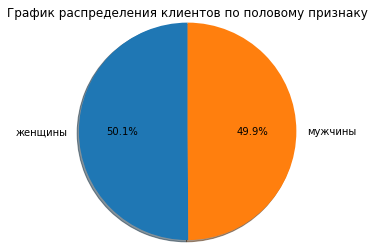

In [6]:
# распределение полов
plt.title('График распределения клиентов по половому признаку')
plt.pie(df['sex'].value_counts(),
        labels=['женщины', 'мужчины'],
        autopct='%1.1f%%',
        startangle=90,
        shadow=True,
        radius=1.25)
plt.show()

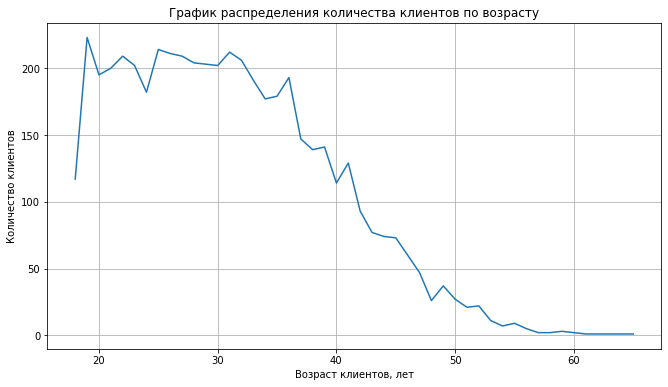

In [7]:
# распределение возрастов
age_distribution = df['age'].value_counts().to_frame().reset_index().sort_values(by='index')
age_distribution.plot(x='index', y='age', grid=True, figsize=(11, 6), legend=False,
                      title='График распределения количества клиентов по возрасту',
                      ylabel='Количество клиентов',
                      xlabel='Возраст клиентов, лет')
plt.show()

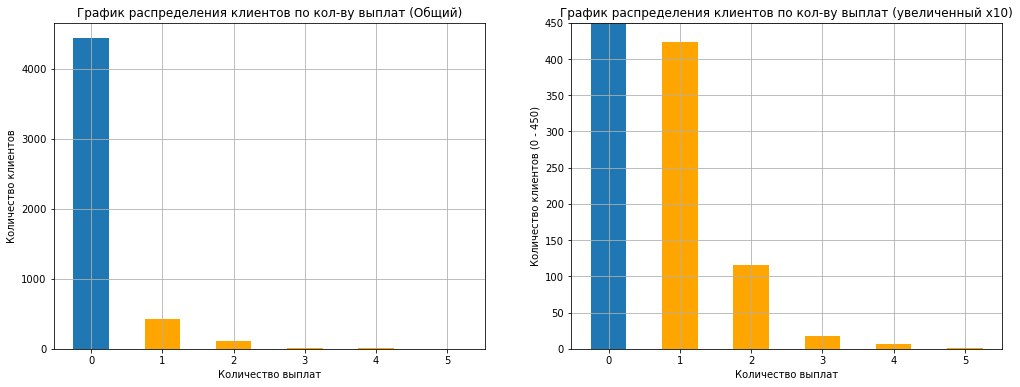

In [8]:
# распределение выплат
fig, axs = plt.subplots(1, 2, figsize=(17, 6))
axs[0].hist(df.loc[df['payments']==0, 'payments'], bins=11, range=(-0.25, 5.25))
axs[0].hist(df.loc[df['payments']>=1, 'payments'], bins=11, range=(-0.25, 5.25), color='orange')
axs[0].set_title('График распределения клиентов по кол-ву выплат (Общий)')
axs[0].set_ylabel('Количество клиентов')
axs[0].set_xlabel('Количество выплат')
axs[0].grid()

axs[1].hist(df.loc[df['payments']==0, 'payments'], bins=11, range=(-0.25, 5.25))
axs[1].hist(df.loc[df['payments']>=1, 'payments'], bins=11, range=(-0.25, 5.25), color='orange')
axs[1].set_title('График распределения клиентов по кол-ву выплат (увеличенный x10)')
axs[1].set_ylabel('Количество клиентов (0 - 450)')
axs[1].set_xlabel('Количество выплат')
axs[1].set_ylim(0, 450)
axs[1].grid()
plt.show()

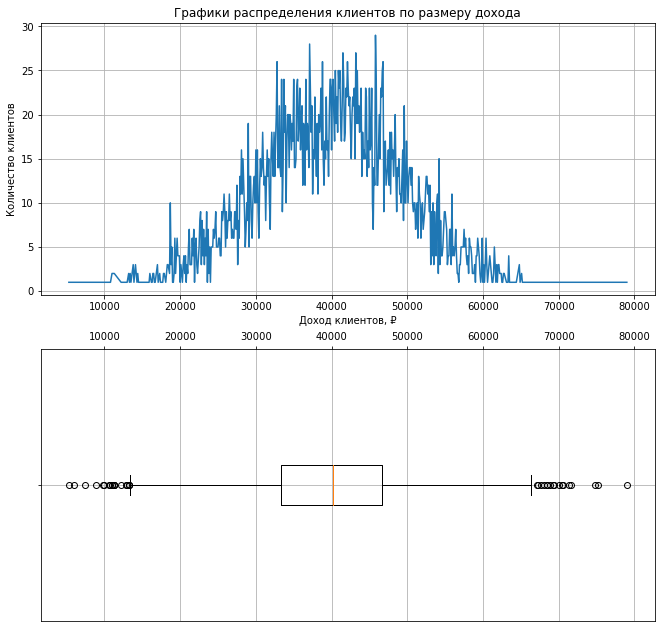

In [9]:
# распределение доходов
income_distribution = df['income'].value_counts().to_frame().reset_index().sort_values(by='index')
fig, axs = plt.subplots(2, 1, figsize=(11, 11))

axs[0].plot('index', 'income', data=income_distribution)
axs[0].set_title('Графики распределения клиентов по размеру дохода')
axs[0].set_ylabel('Количество клиентов')
axs[0].set_xlabel('Доход клиентов, ₽')
axs[0].grid()

axs[1].boxplot(df['income'], vert=False, labels=[''])
axs[1].xaxis.tick_top()
axs[1].grid()
plt.show()

**Вывод:**
- пропуски - отсутствуют,
- тип данных - соответствует,
- аномальные значения - отсутствуют,
- явные дубликаты встречаются в количестве (6%) - это могут быть совпадение. При таком небольшом количестве это возможно.
___

<a id='task'></a>
## Умножение матриц

**Задача:** Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии?
- **a.** Изменится. Приведите примеры матриц.
- **b.** Не изменится. Указать, как связаны параметры линейной регрессии в исходной задаче и в преобразованной.

**Обозначения**:

- $X$ — матрица признаков $(5, 5000)$ (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — квадратная обратимая матрица $(5, 5)$, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу $w_0$)

Предсказания в векторном виде:
$$
a = Xw
$$

Задача обучения:
$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения (вектора весов):
$$
w = \Bigl( X^{T}X \Bigl)^{-1} X^T y
$$

**Ответ:** **b.** Не изменится, т.к. в процессе вычисления вектора предсказания $a$, матрица $Р$ умножается на свою обратную матрицу $Р^{-1}$, сокращаясь до единичной матрицы $E$.

<a id='confirmation'></a>

**Обоснование:** Составлю систему уравнений, состоящую из: задачи предсказания в векторном виде и формулы вектора весов, где матрица предсказаний $Х$ уже домножена на матрицу $Р$:

\begin{cases}
    a = (XP)w \\
    w = \Bigl((XP)^T (XP)\Bigl)^{-1} (XP)^T \times y
\end{cases}

подставлю вектор весов $w$ в формулу вектора предсказаний: $a$:

$$
a = (XP) \Bigl((XP)^T (XP)\Bigl)^{-1} (XP)^T \times y
$$

воспользуюсь с-ом транспонированных матриц $(А B)^{T} = B^{T} A^{T}$:

$$
a = (XP) \Bigl(P^{T}X^{T} (XP)\Bigl)^{-1} P^{T}X^{T} \times y
$$

воспользуюсь с-ом умножения матриц (**ассоциативность**):

$$
a = (XP) \Bigl(P^{T}(X^{T}X)P\Bigl)^{-1} P^{T}X^{T} \times y
$$

воспользуюсь с-ом обратных матриц $(А B)^{-1} = B^{-1} A^{-1}$:

$$
a = (XP) P^{-1} \Bigl((X^{T}X)\Bigl)^{-1} (P^{T})^{-1} P^{T}X^{T} \times y
$$

снова воспользуюсь с-ом **ассоциативности**:

$$
a = X(PP^{-1}) \Bigl((X^{T}X)\Bigl)^{-1} ((P^{T})^{-1} P^{T}) X^{T} \times y
$$


воспользуюсь с-ом обратных матриц $AA^{-1} = A^{-1}A = E$:

$$
a = X E \Bigl((X^{T}X)\Bigl)^{-1} E X^{T} \times y
$$

и т.к. $AE = EA = A$, то:

$$
a = X \Bigl( X^{T}X \Bigl)^{-1} X^{T} y
$$

**Вывод:** умножение матрицы признаков $Х$ на квадратную, обратимую матрицу $Р$ - не изменяет значения вектора предсказаний $a$.
___

## Алгоритм преобразования

Алгоритм представляет собой умножения матрицы признаков $X$ на некоторую матрицу $P$, отвечающая следующим требованиям:

- матрица должны быть квадратной
- ширина/высота матрицы $P$ должны ровняться ширине матрицы $Х$ (т.е. размерность $P$ определяться количеством признаков)
- для матрицы $P$ должна существовать обратная матрица $P^{-1}$

При матричном умножении $(X \times P)$ результатом является новая матрица $Х_{new}$, размерность которой равна размерности исходной матрицы $X$. Таким образом значения признаком будут закодирован как произвольной набор чисел, а матрица $P$ будет являться ключем для кодирования/декодирования.

$$Х_{new} = (X \times P)$$

**Обоснование:** умножение матрицы признаков $Х$ на квадратную, обратимую матрицу $Р$ - не изменяет значения вектора предсказаний $a$. (Подробное математическое обоснование описано в [предыдущем разделе](#confirmation))

**Техническая реализации алгоритма:**
1. для воспроизводимости эксперимента были зафиксированы условия с помощь `np.random.seed()`
2. генерирование произвольной матрицы $P$, значения которой целые числа в диапазоне $[1; 9]$, включительно.
3. контроль обратимости созданной матрицы $P$ (используется свойство: $AA^{-1} = E$)
4. выполнение матричного умножения между $X$ (из аргумента функции) и $P$.

Ниже приведён пример кодирования единичной матрицы $E$ размером $(5, 5)$.

In [10]:
def encoding(X):
    np.random.seed(42)
    P = np.random.randint(low=1, high=10, size=(X.shape[1], X.shape[1]))
    P_inv = np.linalg.inv(P)
    if np.allclose(np.dot(P, P_inv), np.eye(P.shape[1])):
        X_new = X.dot(P)
    return X_new

print('Исходная единичная матрица E (5, 5):\n', np.eye(5))
print('\nЗакодированная матрица:\n', encoding(np.eye(5)))

Исходная единичная матрица E (5, 5):
 [[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]

Закодированная матрица:
 [[3. 6. 2. 5. 6.]
 [3. 2. 7. 2. 8.]
 [7. 1. 3. 2. 3.]
 [7. 8. 8. 8. 9.]
 [8. 2. 8. 5. 1.]]


_Примечания_:

Каждый элемент матрицы $P$ равный 0 - уменьшает вариативность кодирования, т.к. при в матричном умножении некоторые элементы матрицы не будут участвовать в формировании новых значений закодированной матрицы $Х_{new}$. По этой причине ноль не входит в диапазон возможных значений. При необходимости, вариативность можно увеличить задав более высокий предел диапазона значений матрицы $P$.

___

## Проверка алгоритма

Поскольку основные выражения для _обучения_ и _предсказаний_ линейно регрессии были описаны в [исходном задании проекта](#task), и они же использовались для математического обоснования принципа работы алгоритма, их же стоит использовать и при проверки работоспособности алгоритма для бóльшей наглядности. Но согласно заданию, я буду использовать уже готовую модель линейной регрессии из библиотеки **sklearn**, благо она базируется на тех же математических выражениях.

Отличия до и после преобразования оцениваются с помощью метрики **R2**.

In [11]:
# выделение признаков
target = df['payments']
features = df.drop('payments', axis=1)

# оценка модели до кодирования    
model = LinearRegression()
model.fit(features, target)
predictions = model.predict(features)
print('Метрика R2 до кодирования признаков:    {:.3}'.format(r2_score(target, predictions)))

# оценка модели после кодирования
new_features = encoding(features)
model.fit(new_features, target)
new_predictions = model.predict(new_features)
print('Метрика R2 после кодирования признаков: {:.3}'.format(r2_score(target, new_predictions)))

Метрика R2 до кодирования признаков:    0.425
Метрика R2 после кодирования признаков: 0.425


**ИТОГ:**
На практике разница в качестве предсказаний "до" и "после" - отсутствует. Следовательно, кодирование данных с помощью "матричного умножения" не влияет на предсказания модели. Стоит учитывать, что кодирование данных должно происходить до обучения модели.

Алгоритм применим и для другого кол-ва признаков. Для матрицы $P$ можно задать собственную уникальную комбинацию значений, которая станет выполнять роль _ключа_ к кодированию/декодированию данных. Для декодирования матрицы признаков её необходимо умножить на обратную матрицу $P^{-1}$. _Ключ_ можно передавать и использовать между несколькими сотрудниками.

___

## Чек-лист проверки

- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные загружены
- [x]  Выполнен шаг 2: получен ответ на вопрос об умножении матриц
    - [x]  Указан правильный вариант ответа
    - [x]  Вариант обоснован
- [x]  Выполнен шаг 3: предложен алгоритм преобразования
    - [x]  Алгоритм описан
    - [x]  Алгоритм обоснован
- [x]  Выполнен шаг 4: алгоритм проверен
    - [x]  Алгоритм реализован
    - [x]  Проведено сравнение качества моделей до и после преобразования